# Test task for DataRobot
## Problem Overview 

Predicting loan defaults is an extremely common use case for machine learning in banking, one
of DataRobot’s main target industries. As a loan officer, you are responsible for determining
which loans are going to be the most profitable and worthy of lending money to. Based on a
loan application from a potential client, you would like to predict whether the loan will be paid
back in time.

Let's rock!

## Imports


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import logging
import datetime
import nltk
import gensim
import gensim.downloader as api
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.metrics import f1_score, log_loss
from sklearn.neural_network import MLPClassifier

warnings.filterwarnings("ignore")

%matplotlib inline

## Config and helpers

In [2]:
class Constants():
    """
    Constants class encapsulate constant values 
    that are used all over the project
    """
    DATA_FILE = 'DR_Demo_Lending_Club.csv'
    COLUMN_TYPES = {'home_ownership': str, 'verification_status': str, 
                    'pymnt_plan': str, 'purpose_cat': str, 
                    'purpose': str, 'addr_state': str, 
                    'initial_list_status': str, 'policy_code': str, 
                    'emp_length': float, 'annual_inc': float,
                    'debt_to_income': float, 'delinq_2yrs': float,
                    'inq_last_6mths': float, 'mths_since_last_delinq': float,
                    'mths_since_last_record': float, 'open_acc': float,
                    'pub_rec': float, 'revol_bal': float, 
                    'revol_util': float, 'total_acc': float, 
                    'collections_12_mths_ex_med': float, 'mths_since_last_major_derog': float,
                    'Notes': str, 'emp_title': str, 
                    'zip_code': str, 'earliest_cr_line': str, 'Id': int, 'is_bad': int}
    INDEX_COL = 'Id'
    TARGET_COL = 'is_bad'
    DATETIME_COLS = ['earliest_cr_line']
    TEXT_COLS = ['purpose', 'Notes']
    NUMERIC_COLS = ['emp_length', 'annual_inc', 'debt_to_income', 'delinq_2yrs', 'inq_last_6mths',
                    'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
                    'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 
                    'collections_12_mths_ex_med', 'mths_since_last_major_derog']
    CAT_COLS = ['home_ownership', 'verification_status', 'pymnt_plan', 
                'purpose_cat', 'addr_state', 'initial_list_status', 'policy_code']
    NA_ZERO_COLS = ['mths_since_last_delinq', 'mths_since_last_record']
    FILL_MEDIAN_COLS = ['emp_length', 'annual_inc', 'debt_to_income', 'delinq_2yrs', 'inq_last_6mths',
                        'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 
                        'collections_12_mths_ex_med', 'mths_since_last_major_derog']
    NA_VALS = ['NA', 'na', '', np.nan, None, 'NONE', 'none']
    STATE_SUBS = {'TX': 'south', 'KS': 'midwest', 'CA': 'west', 'NY': 'northeast', 'OH': 'midwest',
                  'DC': 'south', 'NV': 'west', 'IL': 'midwest', 'WA': 'west', 'DE': 'south', 
                  'FL': 'south', 'NJ': 'northeast', 'OK': 'south', 'VA': 'south', 'NH': 'northeast',
                  'MA': 'northeast', 'NC': 'south', 'OR': 'west', 'GA': 'south', 'CO': 'west', 
                  'MD': 'south', 'CT': 'northeast', 'MO': 'midwest', 'WI': 'midwest', 'AZ': 'west', 
                  'SC': 'south', 'MN': 'midwest', 'MI': 'midwest', 'PA': 'northeast', 'AK': 'west', 
                  'AR': 'south', 'LA': 'south', 'HI': 'west', 'WV': 'south', 'KY': 'south', 
                  'RI': 'northeast', 'AL': 'south', 'SD': 'midwest', 'NM': 'west', 'ID': 'west', 
                  'UT': 'west', 'MT': 'west', 'WY': 'west', 'VT': 'northeast', 'TN': 'south', 
                  'IA': 'midwest', 'MS': 'south', 'NE': 'midwest', 'IN': 'midwest', 'ME': 'northeast'}
    STOPWORDS = nltk.corpus.stopwords.words('english')
    
const = Constants()

### Data saver and loader

In [3]:
def load_df(file):
    """
    Loads data from csv-like file in to DataFrame
    :param file: str, name of a file on disk or URL
    :return: pandas DataFrame
    """
    return pd.read_csv(file, header=0, dtype=const.COLUMN_TYPES, 
                       index_col=const.INDEX_COL, na_values=const.NA_VALS)


def save_data(data, file):
    """
    Serializes data object to pickle file
    :param data: object, a data to save
    :param file: str, path or filename to save file to
    :return: 
    """
    try:
        with open(file) as dest:
            pkl.dump(data, dest)
    except Exception as e:
        loggin.warn('Error saving data')

Now let's first download the data and make a brief overview of what structure it has.

In [4]:
data_original = load_df(const.DATA_FILE)

In [5]:
data_original.head()

,is_bad,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,Notes,purpose_cat,purpose,...,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
Id,,,,,,,,,,,,,,,,,,,,,
1,0,Time Warner Cable,10.0,MORTGAGE,50000.0,not verified,n,NaN,medical,Medical,...,NaN,15.0,0.0,12087.0,12.1,44.0,f,0.0,1.0,PC4
2,0,Ottawa University,1.0,RENT,39216.0,not verified,n,Borrower added on 04/14/11 > I will be using...,debt consolidation,My Debt Consolidation Loan,...,NaN,4.0,0.0,10114.0,64.0,5.0,f,0.0,2.0,PC1
3,0,Kennedy Wilson,4.0,RENT,65000.0,not verified,n,NaN,credit card,AP Personal Loan,...,NaN,4.0,0.0,81.0,0.6,8.0,f,0.0,3.0,PC4
4,0,TOWN OF PLATTEKILL,10.0,MORTGAGE,57500.0,not verified,n,NaN,debt consolidation,Debt Consolidation Loan,...,NaN,6.0,0.0,10030.0,37.1,23.0,f,0.0,2.0,PC2
5,0,Belmont Correctional,10.0,MORTGAGE,50004.0,VERIFIED - income,n,"I want to consolidate my debt, pay for a vacat...",debt consolidation,consolidate,...,NaN,8.0,0.0,10740.0,40.4,21.0,f,0.0,3.0,PC3


# Data exploration

First of we need to inspect the data for NaN values. It is crucial as not all ML models can deal with absent data. 

### Check which columns contain nans

Firstly, let's check numeric columns and decide on which strategy to use for dealing with outliers.

In [6]:
data_original[const.NUMERIC_COLS].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 14 columns):
emp_length                     9750 non-null float64
annual_inc                     9999 non-null float64
debt_to_income                 10000 non-null float64
delinq_2yrs                    9995 non-null float64
inq_last_6mths                 9995 non-null float64
mths_since_last_delinq         3684 non-null float64
mths_since_last_record         840 non-null float64
open_acc                       9995 non-null float64
pub_rec                        9995 non-null float64
revol_bal                      10000 non-null float64
revol_util                     9974 non-null float64
total_acc                      9995 non-null float64
collections_12_mths_ex_med     9968 non-null float64
mths_since_last_major_derog    10000 non-null float64
dtypes: float64(14)
memory usage: 1.1 MB


As we can see, some columns have little number of nans. That's not a big deal. 

On the other hand, there are these columns, where more that half values are missing. 

We should inspect those and decide what to do next. 

First of let's check `mths_since_last_delinq` (Number of months since the load applicant last
missed a loan repayment) column. It has only 36.8% of data. But the meaning of nans here can vary. 

Ideally if the column contains nan value, it means, that an applicant has never missed a loan repayment.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3E2409D30>]],
      dtype=object)

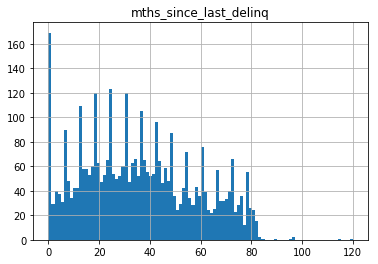

In [7]:
data_original.hist('mths_since_last_delinq', bins=100)

We can see peaks - each 3 month. Also there are many 0 values. However, as we can see later, the ratio of `is_bad` between those who has 0 `mths_since_last_delinq` is almost the same as among all in the dataset. 

In [8]:
# Count is_bad ratio between those with 0 mths_since_last_delinq
is_bads = data_original[data_original['mths_since_last_delinq'] == 0]['is_bad']
np.count_nonzero(is_bads) / is_bads.shape[0]

0.09202453987730061

In [9]:
# Count is_bad ratio between all
is_bads = data_original['is_bad']
np.count_nonzero(is_bads) / is_bads.shape[0]

0.1295

In such situation, the best option would be to create two more columns: `mths_since_last_delinq_0` and `mths_since_last_delinq_na` where 1 would contain rows where `mths_since_last_delinq` equals to 0 and NaN respectively. 

In `mths_since_last_delinq` we will fill nans with 0. 

Worse is the situation with `mths_since_last_record` column.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A3E1529FD0>]],
      dtype=object)

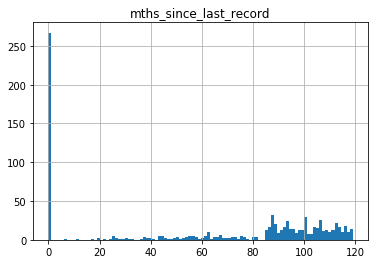

In [10]:
data_original.hist('mths_since_last_record', bins=100)

So it seems like a good idea to deal with this column in the same way as with `mths_since_last_record`.

All the other columns we will fill with the median value of the respective column.

### Exploring datetime columns

In [11]:
data_original[const.DATETIME_COLS].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 1 columns):
earliest_cr_line    9995 non-null object
dtypes: object(1)
memory usage: 156.2+ KB


Checking datetime format to understand how to parse data.

In [12]:
data_original[const.DATETIME_COLS].head()

,earliest_cr_line
Id,
1,12/01/1992
2,11/01/2005
3,06/01/1970
4,09/01/1982
5,10/01/1999


Seems like the date is in an american format: month-day-year. All 5 missing values can be filled with forward fill method. 

Later we can engineer features from this particular column, as raw date values gives no usefut information at all.

### Other columns

Let's check categorical columns and decide how to deal with them. It seems obvious that for small number of unique values, one hot encoding is feasible option, however the problem lies in those features that have large numebr of unique values.

In [13]:
def check_n_uniques(data, columns):
    """
    For every column print number of unique values in the column 
    and whether the column has NaN values  
    :param data: pandas DataFrame, data to search in
    :return:
    """
    for column in columns:
        uniques = data[column].str.lower().unique()
        print(f'Number of unique value in column {column}: {uniques.shape[0]}' 
              f'(Has nans: {has_common(uniques, const.NA_VALS)})')

        
def has_common(list0, list1):
    """
    Returns the result of checking whether two lists contain same elements
    :param list0: list
    :param list1: list
    :return: bool
    """
    return bool(set(list0) & set(list1))

In [14]:
# Checking for unique values in categorical columns
check_n_uniques(data_original, const.CAT_COLS)

Number of unique value in column home_ownership: 5(Has nans: True)
Number of unique value in column verification_status: 3(Has nans: False)
Number of unique value in column pymnt_plan: 2(Has nans: False)
Number of unique value in column purpose_cat: 27(Has nans: False)
Number of unique value in column addr_state: 50(Has nans: False)
Number of unique value in column initial_list_status: 2(Has nans: False)
Number of unique value in column policy_code: 5(Has nans: False)


All columns contains not too many unique values, moreover there are no nans in each of these columns (except `home_ownership`), so we can deal with them as with categorical features. 

Columns with only 2 unique values will be converted to one column - containing 0 or 1, other columns will be one-hot encoded.

Let's check `purpose` column.

In [15]:
data_original['purpose_cat'].unique()

array(['medical', 'debt consolidation', 'credit card', 'other', 'car',
       'wedding', 'other small business', 'house', 'small business',
       'educational', 'major purchase', 'home improvement', 'vacation',
       'debt consolidation small business', 'moving',
       'credit card small business', 'wedding small business',
       'small business small business', 'home improvement small business',
       'major purchase small business', 'educational small business',
       'house small business', 'renewable energy',
       'moving small business', 'medical small business',
       'vacation small business', 'car small business'], dtype=object)

`purpose_cat` column contains too many repeating information about categories that are related to small business. We can deal with it by creating new column `purpose_cat_small_business` that will contain 1 for every value that contains `small business` phrase. Other values we will deal with just like categorical.  

Another column with large number of unique values is `addr_state`.

In [16]:
data_original['addr_state'].unique()

array(['TX', 'KS', 'CA', 'NY', 'OH', 'DC', 'NV', 'IL', 'WA', 'DE', 'FL',
       'NJ', 'OK', 'VA', 'NH', 'MA', 'NC', 'OR', 'GA', 'CO', 'MD', 'CT',
       'MO', 'WI', 'AZ', 'SC', 'MN', 'MI', 'PA', 'AK', 'AR', 'LA', 'HI',
       'WV', 'KY', 'RI', 'AL', 'SD', 'NM', 'ID', 'UT', 'MT', 'WY', 'VT',
       'TN', 'IA', 'MS', 'NE', 'IN', 'ME'], dtype=object)

`addr_state` contains 50 categories, thus 50 new columns will be created after one-hot encoding. To prevent this we will substitute state names with region names (e.g. Notheast, Midwest etc.) according to United States Census Bureau.

# Preprocessing the data

## Preprocessing pipeline helpers

Here we define helping functions that we will use to preprocess the data.

In [17]:
def na_zero_to_separate_column(data, columns):
    """
    Extract zero and NaN values as one-hot encoded binary columns 
    and fill NaN values in target column with zeros 
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    for column in columns:
        # Create separate columns for different values
        data_modified[column + '_na'] = data_modified[column].isna()
        data_modified[column + '_0'] = data_modified[column] == 0
    # Fill with zeros
    fill_values = {col: 0 for col in columns}
    data_modified = data_modified.fillna(value=fill_values)
    return data_modified


def to_datetime(data, columns):
    """
    Convert values in target columns to datetime object
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    data_modified[columns] = data_modified[columns].apply(pd.to_datetime, 
                                                          format='%m/%d/%Y', 
                                                          infer_datetime_format=True)
    return data_modified


def to_one_hot(data, columns):
    """
    Convert values in target columns to one-hot encoded columns
    Columns are named as `target_column` + index
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    return pd.get_dummies(data_modified, columns=columns)


def fill_na_median(data, columns):
    """
    Fill absent values in target columns 
    with median values in the column
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    median = data_modified[columns].median()
    data_modified[columns] = data_modified[columns].fillna(median)
    return data_modified


def ffill_na(data, columns):
    """
    Fill absent values in target columns with forward fill method
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    data_modified[columns] = data_modified[columns].fillna(method='ffill')
    return data_modified


def deal_with_purpose_cat(data, column='purpose_cat', phrase='small business'):
    """
    Create separate column for `purpose_cat` column indicating small business.
    All values from the column, that contain small business in values will have 1 in the new column.
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    small_business_mask = data_modified[column].str.contains(phrase)
    data_modified[column + '_small_business'] = small_business_mask
    data_modified.loc[small_business_mask, column] = \
        data_modified.loc[small_business_mask, column].str.replace(phrase, '').str.strip()
    return data_modified


def deal_with_state_codes(data, column='addr_state', subs=const.STATE_SUBS):
    """
    Exchange status codes to substitution values
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    data_modified[column] = data_modified[column].apply(lambda x: subs[x])
    return data_modified

### Apply pipeline

In [18]:
# Extract NaNs in separate columns
data_na_fixed = na_zero_to_separate_column(data_original, const.NA_ZERO_COLS)
# Fill NaNs with median values
data_na_med = fill_na_median(data_na_fixed, const.FILL_MEDIAN_COLS)
# Fill NaNs in datetime columns
data_na_ffiled = ffill_na(data_na_med, const.DATETIME_COLS)
# Convert datetime columns to datetime type
data_na_dt = to_datetime(data_na_ffiled, const.DATETIME_COLS)
# Deal with purpose_cat column
data_na_dt_pupr = deal_with_purpose_cat(data_na_dt)
# Substitute state codes
data_na_dt_purp_state = deal_with_state_codes(data_na_dt_pupr)
# Convert other categorical features to one-hot encoding
data_na_dt_purp_state_oh = to_one_hot(data_na_dt_purp_state, const.CAT_COLS)

In [19]:
# Check what's left unprocessed
check_n_uniques(data_na_dt_purp_state, const.CAT_COLS)

Number of unique value in column home_ownership: 5(Has nans: True)
Number of unique value in column verification_status: 3(Has nans: False)
Number of unique value in column pymnt_plan: 2(Has nans: False)
Number of unique value in column purpose_cat: 14(Has nans: True)
Number of unique value in column addr_state: 4(Has nans: False)
Number of unique value in column initial_list_status: 2(Has nans: False)
Number of unique value in column policy_code: 5(Has nans: False)


## Dealing with text data

There are several columns in the dataset that contain text. These columns can give us valuable insights.

In [20]:
def extract_date_features(data, columns):
    """
    Create new columns from the datetime column. 
    New columns include how many days ago does was the referred date. 
    And which month of the year does the date refer to.
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    for column in columns:
        data_modified[column + '_days_ago'] = datetime.datetime.now() - data_modified[column]
        data_modified[column + '_days_ago'] = data_modified[column + '_days_ago'].apply(lambda x: x.days)
        data_modified[column + '_month'] = data_modified[column].apply(lambda x: x.month)
    return data_modified


def fillna_text(data, columns):
    """
    Deal with absent data in target text columns
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    data_modified[columns] = data_modified[columns].fillna('').astype(str)
    return data_modified


def to_lower(data, columns):
    """
    Convert all text from target column to lower case
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    for column in columns:
        data_modified[column] = data_modified[column].str.lower()
    return data_modified


def remove_other_phrases(data, columns, patterns=["borrower added on [0-9]+/[0-9]+/[0-9]+", 
                                                  "<[\w]+[/]?>", ">", "[0-9]+"]):
    """
    Replace given text or patterns in text to empty string.
    Some cases are: typical phrases, html tags, some punctuation and numbers
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :param patterns: list, patterns to match
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    for pattern in patterns:
        for column in columns:
            data_modified[column] = data_modified[column].str.replace(pattern, '')
    return data_modified


def remove_punctuation(data, columns):
    """
    Remove all non-alpha and non-numeric symbols from text
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    for column in columns:
        data_modified[column] = data_modified[column].str.replace('[^\w\s]', '')
    return data_modified


def stemming(data, columns):
    """
    Stem the words. Return only neutral form of each word without sufixes or prefixes
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    stemmer = nltk.stem.PorterStemmer()
    for column in columns:
        data_modified[column] = data_modified[column].apply(
            lambda sent: ' '.join([stemmer.stem(word) for word in sent.split()]))
    return data_modified


def get_most_less_freq(data, columns, top=10):
    """
    Return the top most and the least frequent words
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :param top: int, number of first and last frequent words
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    result = {}
    for column in columns:
        frequency = pd.Series(' '.join(data_modified[column]) \
                              .split()).value_counts()
        remove_words = list(frequency.index)[:top] + list(frequency.index)[-top:]
        result[column] = remove_words
    return result
    

def tokenize_words(data, column):
    """
    Tokenize strings. Create list of separate words for each value.
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    data_modified[column] = data_modified[column].apply(nltk.tokenize.word_tokenize)
    return data_modified


def remove_stopwords(data, column, stopwords):
    """
    Remove the words from stopwords list from text.
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :param stopwords: lsit, short or too frequent words
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    data_modified[column] = data_modified[column].apply(
        lambda tokens: [w for w in tokens if not w in stopwords])
    return data_modified


def embed_text_columns(data, columns, model):
    """
    For each string representation create new embedding columns
    :param data: pandas DataFrame, data to preprocess
    :param columns: list, target columns
    :param model: object, embedding model
    :return: pandas DataFrame, preprocessed data
    """
    data_modified = data.copy()
    result = [data_modified]
    for column in columns:
        embeddings = data_modified[column].apply(lambda x: list_embedding(x, model))
        embeddings_df = pd.DataFrame(np.vstack(embeddings.values), 
                                     columns=[column + '_' + str(i) for i in range(embeddings.values[0].shape[0])],
                                     index=data_modified[column].index)
        result.append(embeddings_df)
    return pd.concat(result, sort=False, axis=1)

        
def list_embedding(data, model):
    """ TODO
    Get string embedding
    :param data: list, tokenized string
    :param model: object, embedding model
    :return: numpy array, embedding
    """
    result = []
    for item in data:
        try:         
            result.append(model[item])
        except KeyError:
            result.append(np.zeros((25,)).astype(np.float32))
    return np.sum(np.array(result), axis=0) / len(data)  \
            if len(data) > 0 else np.zeros((25,)).astype(np.float32)

In [21]:
# Preprocess date
data_fixed_date = extract_date_features(data_na_dt_purp_state_oh, const.DATETIME_COLS)
# Deal with absent text
data_fixed_date_text_na = fillna_text(data_fixed_date, const.TEXT_COLS)
# Cast text to lower case
data_text_lower = to_lower(data_fixed_date_text_na, const.TEXT_COLS)
# Clean text
data_text_clean = remove_other_phrases(data_text_lower, const.TEXT_COLS)
# Remove puctuation
data_text_no_punct = remove_punctuation(data_text_clean, const.TEXT_COLS)
# Stem text data
data_text_stemmed = stemming(data_text_no_punct, const.TEXT_COLS)
# Get most and least frequent words
most_less_freq = get_most_less_freq(data_text_stemmed, const.TEXT_COLS)
# Tokenize text data
for column in const.TEXT_COLS:
    data_text_stemmed = tokenize_words(data_text_stemmed, column)
# Remove frequent words
for column in const.TEXT_COLS:
    freq = most_less_freq[column]
    data_text_stemmed = remove_stopwords(data_text_stemmed, column, const.STOPWORDS + freq)

In [22]:
# Load embedding model
w2v = api.load("glove-twitter-25")
# Get embeddings
data_text_embedded = embed_text_columns(data_text_stemmed, const.TEXT_COLS, w2v)

#  Final data selection

We should deal with column that we took information from and that are no more useful for us.

In [23]:
drop_columns = ['is_bad', 'emp_title', 'Notes', 'purpose', 'zip_code', 'earliest_cr_line',
       'home_ownership_OTHER', 'verification_status_not verified', 'pymnt_plan_n', 
        'purpose_cat_', 'initial_list_status_m']

In [24]:
y = data_text_embedded['is_bad']
X = data_text_embedded.drop(columns=drop_columns).astype(np.float64)

#### Normalize all data

In [25]:
sc = StandardScaler(with_mean=True, with_std=True)
X_sc = sc.fit_transform(X)

## Partition data

In [26]:
from sklearn.model_selection import train_test_split

# It's holdout dataset, so we'll keep it fairly small
X_train, X_holdout, y_train, y_holdout = train_test_split(X_sc, y, test_size=0.1, random_state=43, shuffle=False)  

# Prediction

First of we should create baseline model, that we will use to estimate baseline metric. 

Ideally such model should give random result, so the accuracy and f1 score should be near 0.5.

But the thing that we should remember is that our data is imbalanced. And for no means should we use accuracy. Such dummy classifier should be weighted for purpose of more correct result.

In [27]:
class DummyClassifierLocal(BaseEstimator, ClassifierMixin):
    """
    DummyClassifierLocal implements standard sklearn interfaces to be used in sklearn pipelines and estimators.
    """
    def __init__(self, n_classes=2, weights=None):
        """
        Create an instance of DummyClassifierLocal class
        :param n_classes: int, number of unique classes
        :param weights: list, class weights
        :return: DummyClassifierLocal
        """
        self.n_classes = n_classes
        self.weights = weights
        
    def fit(self, X, y=None):
        """
        Train classifier
        :param X: array-like, input data
        :param y: array-like, true labels 
        :return: self
        """
        if getattr(self, 'weights') is None:
            self.p_ = np.ones((1, self.n_classes)) / self.n_classes
        else:
            self.p_ = self.weights
        return self
    
    def predict(self, X, y=None):
        """
        Predicts output values based on input
        :param X: array-like, input data
        :param y: array-like, labels 
        :return: array-like, predicted labels
        """
        return np.random.choice(self.n_classes, size=(X.shape[0]), p=self.p_)
    
    def score(self, X, y=None):
        """
        Counts ratio of true positive to all samples
        :param X: array-like, input data
        :param y: array-like, labels 
        :return: float, score value
        """
        return np.count_nonzero(self.predict(X) == y) / X.shape[0] 

In [32]:
def get_model_cros_val_score(X, y, model, metrics, cv=5):
    result = cross_validate(model, X, y, cv=cv, scoring=metrics, return_estimator=True)
    return result

    
def print_results(result, metrics):
    print(f"\nResults for {result['estimator'][0].__class__.__name__}:")
    for metric in metrics:
        print(f"    {metric}: {np.mean(result['test_' + metric])}")


metrics = ['f1', 'neg_log_loss']
models = [
    LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, tol=10e-5),
    MLPClassifier(hidden_layer_sizes=(30, 20)),
    DummyClassifier(strategy='stratified')
]
model_result = {}

for model in models:
    result = get_model_cros_val_score(X_train, y_train, model, metrics)
    model_result[model.__class__.__name__] = result
    print_results(result, metrics)

    
for label, result in model_result.items():
    y_pred = result['estimator'][0].predict(X_holdout)
    print(f'\nOn holdout set {label}:')
    print(f'    f1: {f1_score(y_holdout, y_pred)}')
    print(f'    negative log_loss: {log_loss(y_holdout, y_pred)}')


Results for LogisticRegression:
    f1: 0.24275254173550126
    neg_log_loss: -0.3384754761312384

Results for MLPClassifier:
    f1: 0.2538150012002564
    neg_log_loss: -1.5349054156343072

Results for DummyClassifier:
    f1: 0.12342267649594267
    neg_log_loss: -7.7252208534482945

On holdout set LogisticRegression:
    f1: 0.23312883435582823
    negative log_loss: 4.317347049363836

On holdout set MLPClassifier:
    f1: 0.3202846975088968
    negative log_loss: 6.596979854391519

On holdout set DummyClassifier:
    f1: 0.12454212454212454
    negative log_loss: 8.254857113295834


## Feature importance estimation

To estimate which features should we select, say in a case when dimensionality reduction is needed, we can use different metrics to estimate feature importances.

However, one should remember, that feature importances, provided by the following tests do not mean the features have the same influence on model. 

Here we will use two approaches: mutual information criteria estimation and f-test. F-test is better at capturing linear dependencies between features, while MI can capture non-linear as well.

In [33]:
def select_k_best_f_val(X, y, top_n):
    selector = SelectKBest(f_classif, k=top_n)
    X_red = selector.fit(X, y)
    scores = np.nan_to_num(-np.log10(selector.pvalues_))
    scores /= scores.max()
    return scores
    
    
def select_k_best_mi(X, y, top_n):
    selector = SelectKBest(mutual_info_classif, k=top_n)
    X_red = selector.fit(X, y)
    scores = selector.scores_
    scores /= scores.max()
    return scores


def print_feature_importances(scores, kind, columns, top_n):
    sorted_idx = np.argsort(scores)[::-1][:top_n]
    columns = columns[sorted_idx]    
    plt.figure()
    plt.title(f"Feature importances by {kind}")
    plt.bar(range(top_n), scores[sorted_idx], color="r", align="center")
    plt.xticks(range(top_n), columns, rotation=90)
    plt.xlim([-1, top_n])

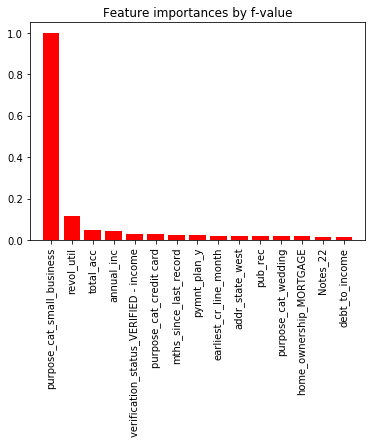

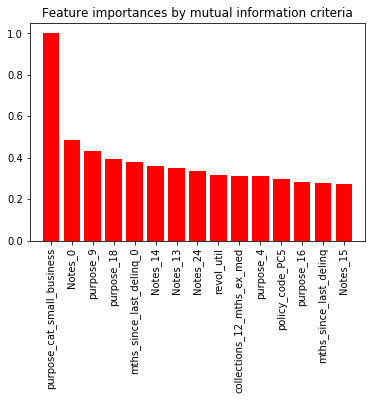

In [34]:
columns = X.columns 
top_n = 15

f_scores = select_k_best_f_val(X_sc, y, top_n)
mi_scores = select_k_best_mi(X_sc, y, top_n)
print_feature_importances(f_scores, 'f-value', columns, top_n)
print_feature_importances(mi_scores, 'mutual information criteria', columns, top_n)
plt.show()

As we can see on plots, each method selected hend-engineered feature that indicates whether the loan is for small business as the most important. Another important feature is `total_acc` (Total number of accounts for the loan applicant).

Among other 15 most important features there are `revol_util` (Loan applicant’s percentage utilization of their
revolving credit facility), `purpose_cat - credit card` and `pub_rec` (The number of public record judgements
against the loan applicant).

Once again, these are just statistical and information theory methods for feature importance estimation, and it may differ to those that model used.

# Conclusions

1. After computing scores, I may conclude, that MLP with two hidden layers is the best model in such case. Even though it trains longer, it gives better result. However, simple linear model such as Logistic Regression fits good as well.

2. Both classifiers are much better (2x) comparing to DummyClassifier by comparing their f1 score.

3. In this work I did not focus on hyperparameters tuning, as it could take another day :D Instead I used some best-fit hyperparameters (including l2 penalized LogRegression).

4. If I had more time, it would be feasible to try using RNN networks to classify text data. Also, the output embeddings from RNN could be concatenated with other data and can be fit in some classifier.
